In [1]:
%matplotlib inline
from importlib import reload
import sys
from LyaPlotter.computations import Computations
from LyaPlotter.plotter import Plotter
from LyaPlotter.sims import CoLoReSim, LyaCoLoReSim, QuickQuasarsSim
import glob
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from matplotlib.gridspec import GridSpec
from CoLoRe_corrf_analysis.fitter import Fitter
from pathlib import Path 
import fitsio 
plt.style.use('tableau-colorblind10') 
from CoLoRe_corrf_analysis.cf_helper import CFComputations, CFComputationsAbacus
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

In [2]:
from astropy.io import fits

In [4]:
# let's grab a Y1 like number density:
exp_dens = np.loadtxt("ngal_per_arcmin2-srd-y1-y10.txt")
print(exp_dens)

Ngal_frac = exp_dens[0]/exp_dens[-1]
print(Ngal_frac)

[17.21432366 23.48951038 28.17435382 32.07871509 35.45324275 38.47662444
 41.2091792  43.77246099 46.15055884 48.37711488]
0.3558360953460096


In [8]:
nztot = np.loadtxt("../nz-gold-roman-rubin-y1-y10.txt")

In [5]:
import yaml

root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/'
packed_stats_fzb_source={}
for year in [1,3,5]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-source-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_fzb_source[year]=yaml.load(stream,Loader=yaml.Loader)

In [6]:
# take some tomo graphic binning:
year = 5
nz_tomo = {}
nz_tomo_nonorm = {}
nz_tomo_tot = 0
for kk in range(5):
    nz = packed_stats_fzb_source[year]["tomo-%d"%(kk+1)]["nztot"]
    y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
    nz_tomo[kk] = np.c_[nz[:,0], y]
    nz_tomo_tot += nz[:,1]
    nz_tomo_nonorm[kk] = nz[:,:2]
    
for kk in range(5):
    nz_tomo_nonorm[kk][:,1] = nz_tomo_nonorm[kk][:,1]/sum(nz_tomo_tot)
nz_tomo_tot = nz_tomo_tot/sum(nz_tomo_tot)/(nz[1,0]-nz[0,0])

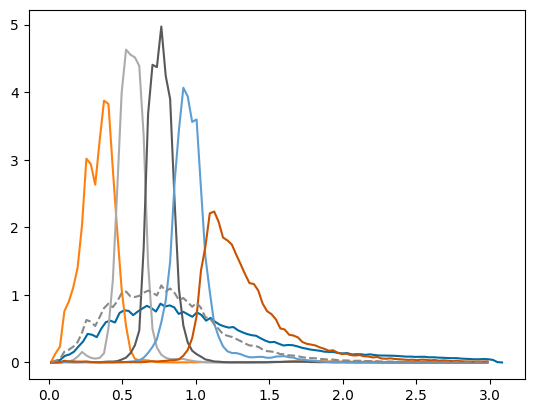

In [7]:
dztot = nztot[1,0]-nztot[0,0]
dz = nz[1,0]-nz[0,0]

plt.plot(nztot[:,0],nztot[:,-1])

for ii in range(5):
    plt.plot(nz_tomo[ii][:,0],nz_tomo[ii][:,1])
    
plt.plot(nz_tomo[ii][:,0], nz_tomo_tot,'--')

0.5582940379159356


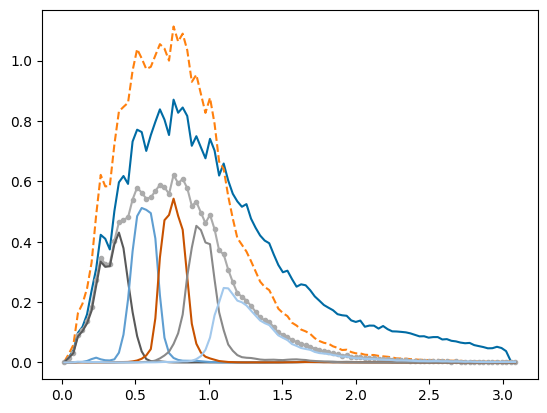

In [8]:
# first interpolate all distributions to ztot bins:

nz_tomo_tot_int = np.interp(nztot[:,0],nz_tomo[0][:,0], nz_tomo_tot)
# normalize
nz_tomo_tot_int = nz_tomo_tot_int/sum(nz_tomo_tot_int)/dztot

nz_tomo_nonorm_int={}
norm = 0
for ii in range(5):
    nz_tomo_nonorm_int[ii]=np.interp(nztot[:,0],nz_tomo[ii][:,0],nz_tomo_nonorm[ii][:,1])
    nz_tomo_nonorm_int[ii]=nz_tomo_nonorm_int[ii]/dztot
    norm += nz_tomo_nonorm_int[ii]
    
# norm
for ii in range(5):
    nz_tomo_nonorm_int[ii] = nz_tomo_nonorm_int[ii]/sum(norm)*sum(nz_tomo_tot_int)

plt.plot(nztot[:,0],nztot[:,-1])
plt.plot(nztot[:,0],nz_tomo_tot_int,'--')

# so now figure out the scaling first:
ratio = nz_tomo_tot_int/nztot[:,-1]
ratio[np.isnan(ratio)]=0
ratio[np.isinf(ratio)]=0
scale=ratio.max()
plt.plot(nztot[:,0],nz_tomo_tot_int/scale,'.-')
print(1/scale)

# now also figure out how to get the tomographic bins:
# first assign each redshift into bins below with index 0-100
# then for each bin, each galaxy is assigned into a tomo bin with some probability given by the tomo curves

for ii in range(5):
    plt.plot(nztot[:,0],nz_tomo_nonorm_int[ii]/scale)

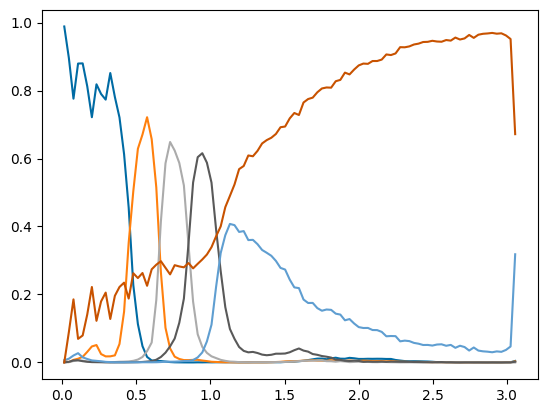

In [9]:
# now get the probability ratio in each z-sampling bin:
for ii in range(5):
    if ii==0:
        ratio= np.c_[nztot[:,0], nz_tomo_nonorm_int[ii]/scale/nztot[:,-1]]
    else:
        ratio = np.c_[ratio, nz_tomo_nonorm_int[ii]/scale/nztot[:,-1]]
    
    plt.plot(ratio[:,0], ratio[:,ii+1])
    # write this out 
    
# last bin: trimmed objects:
ratio=np.c_[ratio, (nztot[:,-1] - nz_tomo_tot_int/scale)/nztot[:,-1]]
plt.plot(ratio[:,0], ratio[:,-1])
    
np.savetxt("tomo-binning-assign-ratio.txt",ratio)

In [10]:
# let's just down sample each bin to 1/5:

# ratio in bins:

zbin_edges = np.append((nztot[:,0]-dztot/2.), (nztot[-1,0]+dztot/2.))

In [11]:
# now try this method:

In [12]:
cumratio = np.cumsum(ratio[:,1:],axis=1)

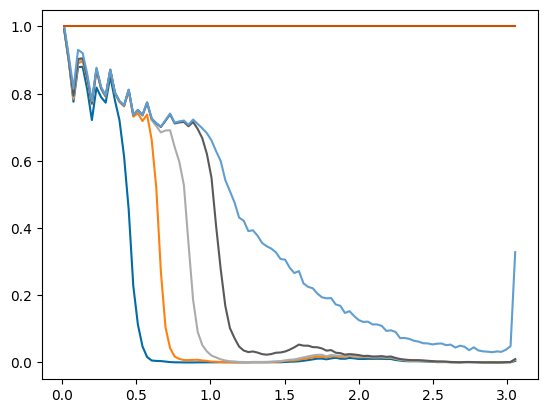

In [13]:
plt.plot(ratio[:,0], cumratio)

# Here load the catalogue in chunks and do the counts on the fly

In [14]:
def get_tomo_bin(redshift, zbin_edges, cumratio, seed):
    np.random.seed(seed)
    bins = np.digitize(redshift, zbin_edges)
    rand = np.random.uniform(size=len(redshift))
    tomo_assign = np.zeros(len(redshift))

    # now digitize the bins:
    for kk in range(len(zbin_edges)-1):
        ind = bins==kk+1
        tomo_assign[ind]=np.digitize(rand[ind], np.append(0, cumratio[kk,:]))
        
    return tomo_assign

In [15]:
nside = 1024
npix = hp.nside2npix(nside)

In [ ]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results/"

galmap={}
galnz={}
seed=1234

for ii in range(128):
    
    if ii%30==0:
        print(f"Working on {ii+1}/128...")
    
    fname = root + f"out_srcs_s2_{ii}.fits"
    f=fits.open(fname)
    
    redshift = f[1].data['Z_COSMO'] + f[1].data['DZ_RSD']
    ra = f[1].data['RA']
    dec = f[1].data['DEC']
    
    # separate into tomographic bins, save galaxy maps + n(z) for each bin:
    tomo_assign = get_tomo_bin(redshift, zbin_edges, cumratio, seed)
    
    for tomo in range(5):
        sel = tomo_assign == tomo + 1
    
        # show map:
        pix = hp.ang2pix(nside,
                         np.radians(90 - dec[sel]),
                         np.radians(ra[sel]))
        n = np.bincount(pix, minlength=npix)
        
        cc = np.histogram(redshift[sel], bins=80, range=[0,3])
        
        if ii == 0:
            galmap[tomo] = n
            galnz[tomo] = np.append(cc[0],0)
        else:
            galmap[tomo] += n
            galnz[tomo] += np.append(cc[0],0)

# now save:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
nzout = cc[1]
for tomo in range(5):
    hp.write_map(saveroot + f"gal-count-tomo-{tomo}-nside-{nside}.fits", galmap[tomo], overwrite=True,
                dtype='int')
    nzout = np.c_[nzout, galnz[tomo]]
np.savetxt(saveroot + "gal-nzcount.txt",nzout)

Working on 1/128...
Working on 31/128...
Working on 61/128...


Check results

In [3]:
# grab the maps:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
nside=1024
galmap={}
for tomo in range(5):
    galmap[tomo] = hp.read_map(saveroot + f"gal-count-tomo-{tomo}-nside-{nside}.fits")
    
galnz = np.loadtxt(saveroot + "gal-nzcount.txt")

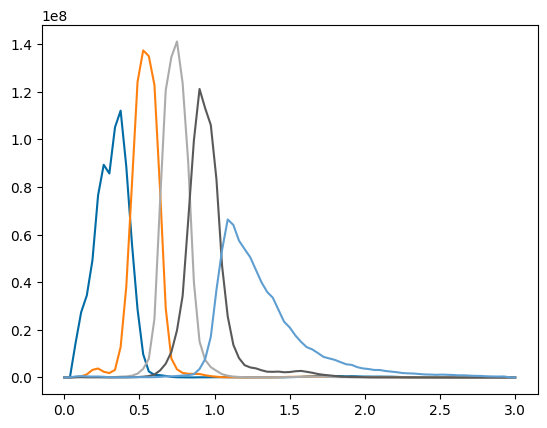

In [28]:
# check:
plt.plot(galnz[:,0],galnz[:,1:])

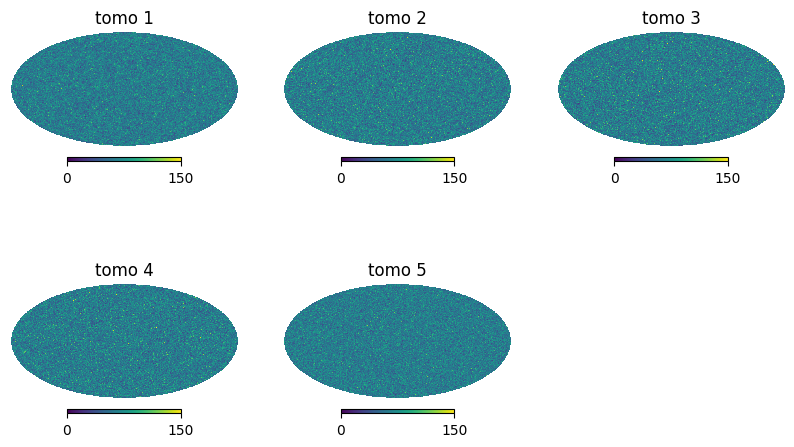

In [4]:
fig,axarr=plt.subplots(2,3,figsize=[10,6])
axarr[1,2].axis("off")
for ii in range(2):
    for jj in range(3):
        kk = ii*3 + jj
        if kk<5:
            plt.sca(axarr[ii,jj])
            hp.mollview(galmap[kk],hold=True,title=f"tomo {kk+1}",min=0,max=150)

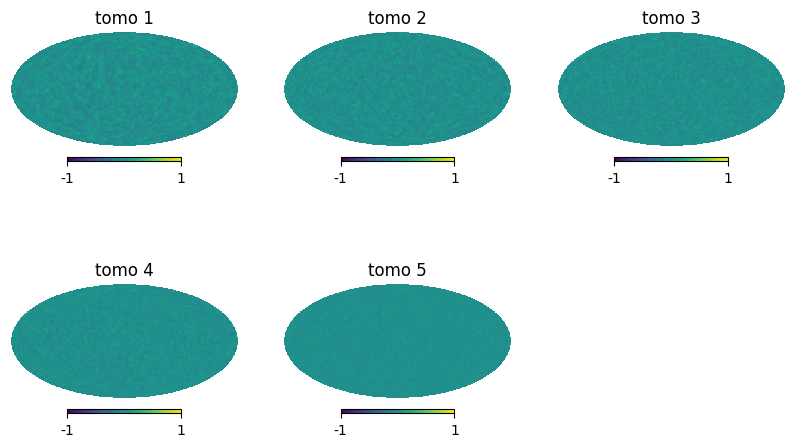

In [8]:
fig,axarr=plt.subplots(2,3,figsize=[10,6])
axarr[1,2].axis("off")
for ii in range(2):
    for jj in range(3):
        kk = ii*3 + jj
        if kk<5:
            plt.sca(axarr[ii,jj])
            densmap=galmap[kk]/np.mean(galmap[kk])-1
            smthmap = hp.sphtfunc.smoothing(densmap, sigma=np.pi/180.)
            hp.mollview(smthmap,hold=True,title=f"tomo {kk+1}",min=-1,max=1)

In [9]:
# now produce the density maps, and measure the clgg:
clgg={}
pshot = np.zeros(5)
for tomo in range(5):
    pshot[tomo]=4*np.pi/sum(galmap[tomo])
    densmap=galmap[tomo]/np.mean(galmap[tomo])-1
    clgg[tomo] = hp.anafast(densmap,lmax=1000)

In [36]:
pshot

array([1.58207143e-08, 1.56882852e-08, 1.56864752e-08, 1.56218187e-08,
       1.56914184e-08])

In [11]:
# load theory:
th = np.loadtxt(saveroot+ "clgg-theory.txt")

In [17]:
cov_gaussian = {}
ell=np.arange(1001)
for ii in range(5):
    cov_gaussian[ii] = 2*th[:,ii]**2/(2*ell + 1)

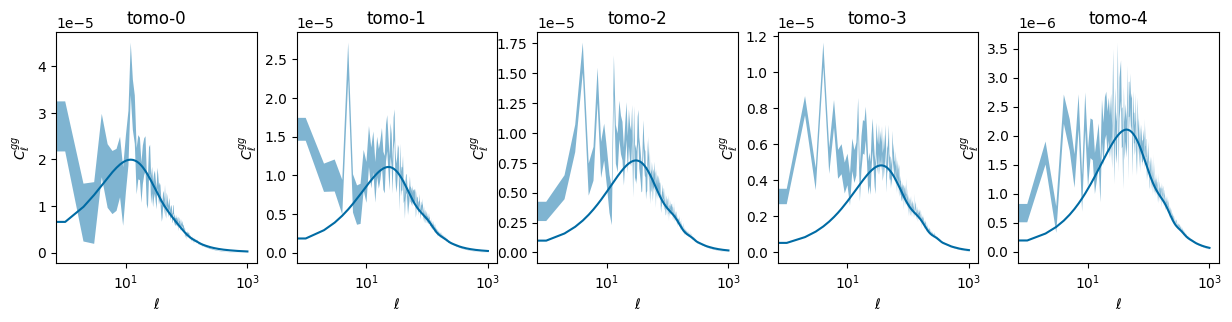

In [18]:
fig,axarr=plt.subplots(1,5,figsize=[15,3])

for tomo in range(5):
    plt.sca(axarr[tomo])
    #plt.semilogx(clgg[tomo]-pshot[tomo])
    y=clgg[tomo]-pshot[tomo]
    dy = np.sqrt(cov_gaussian[tomo])
    plt.fill_between(ell, y-dy, y+dy,alpha=0.5)
    plt.semilogx(th[:,tomo])
    plt.title(f"tomo-{tomo}")
    plt.xlabel("$\\ell$")
    plt.ylabel("$C_{\\ell}^{gg}$")

# try simple tomo bining by cutting on true z:

In [7]:
nside = 1024
npix = hp.nside2npix(nside)
zbin = np.linspace(0.2,2.8,6)

In [10]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results/"

galmap={}
galnz={}
seed=1234

for ii in range(128):
    
    if ii%30==0:
        print(f"Working on {ii+1}/128...")
    
    fname = root + f"out_srcs_s2_{ii}.fits"
    f=fits.open(fname)
    
    redshift = f[1].data['Z_COSMO'] + f[1].data['DZ_RSD']
    ra = f[1].data['RA']
    dec = f[1].data['DEC']
    
    # separate into tomographic bins, save galaxy maps + n(z) for each bin:
    #tomo_assign = get_tomo_bin(redshift, zbin_edges, cumratio, seed)
    
    for tomo in range(5):
        #sel = tomo_assign == tomo + 1
        sel = (redshift > zbin[tomo])&(redshift <= zbin[tomo+1])
    
        # show map:
        pix = hp.ang2pix(nside,
                         np.radians(90 - dec[sel]),
                         np.radians(ra[sel]))
        n = np.bincount(pix, minlength=npix)
        
        cc = np.histogram(redshift[sel], bins=80, range=[0,3])
        
        if ii == 0:
            galmap[tomo] = n
            galnz[tomo] = np.append(cc[0],0)
        else:
            galmap[tomo] += n
            galnz[tomo] += np.append(cc[0],0)

# now save:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
nzout = cc[1]
for tomo in range(5):
    hp.write_map(saveroot + f"gal-count-tomo-{tomo}-nside-{nside}-truezbin.fits", galmap[tomo], overwrite=True,
                dtype='int')
    nzout = np.c_[nzout, galnz[tomo]]
np.savetxt(saveroot + "gal-nzcount-truezbin.txt",nzout)

Working on 1/128...
Working on 31/128...
Working on 61/128...
Working on 91/128...
Working on 121/128...


In [5]:
# grab the maps:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
nside=1024
galmap={}
for tomo in range(5):
    galmap[tomo] = hp.read_map(saveroot + f"gal-count-tomo-{tomo}-nside-{nside}-truezbin.fits")
    
galnz = np.loadtxt(saveroot + "gal-nzcount-truezbin.txt")

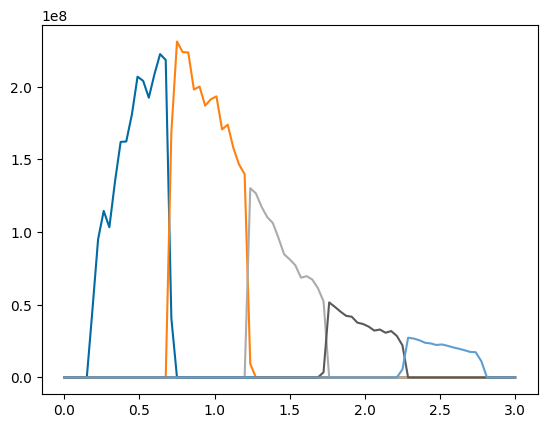

In [6]:
# check:
plt.plot(galnz[:,0],galnz[:,1:])

In [7]:
# now produce the density maps, and measure the clgg:
clgg={}
pshot = np.zeros(5)
for tomo in range(5):
    pshot[tomo]=4*np.pi/sum(galmap[tomo])
    densmap=galmap[tomo]/np.mean(galmap[tomo])-1
    clgg[tomo] = hp.anafast(densmap,lmax=1000)

In [14]:
# load theory:
th = np.loadtxt(saveroot+ "clgg-theory-truezbin.txt")

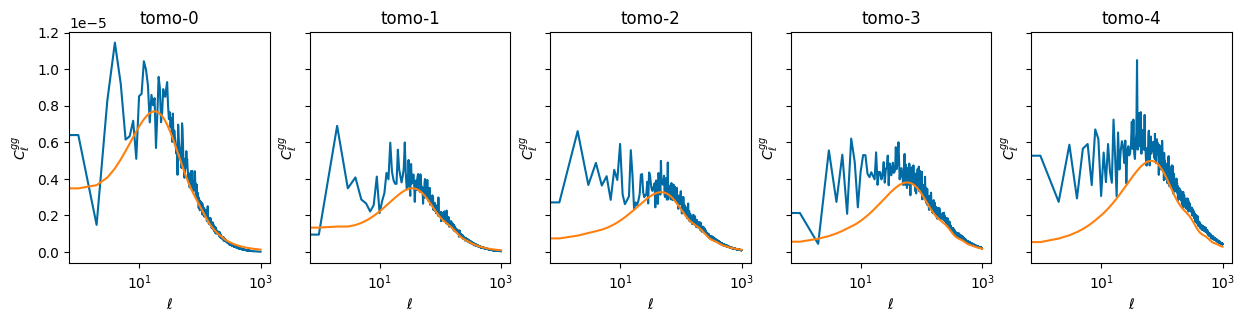

In [15]:
fig,axarr=plt.subplots(1,5,figsize=[15,3],sharey=True)

for tomo in range(5):
    plt.sca(axarr[tomo])
    plt.semilogx(clgg[tomo]-pshot[tomo])
    #y=clgg[tomo]-pshot[tomo]
    #dy = np.sqrt(cov_gaussian[tomo])
    #plt.fill_between(ell, y-dy, y+dy,alpha=0.5)
    plt.semilogx(th[:,tomo])
    plt.title(f"tomo-{tomo}")
    plt.xlabel("$\\ell$")
    plt.ylabel("$C_{\\ell}^{gg}$")

In [4]:
# routine to select the galaxies with target redshift distribution:

# let's first try with the smaller catalogue, how to split into Gaussian:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/unknown-zmin-1.8-zmax-3.0.fits"
fin = fits.open(fname)
z = fin[1].data['Z'][::100]


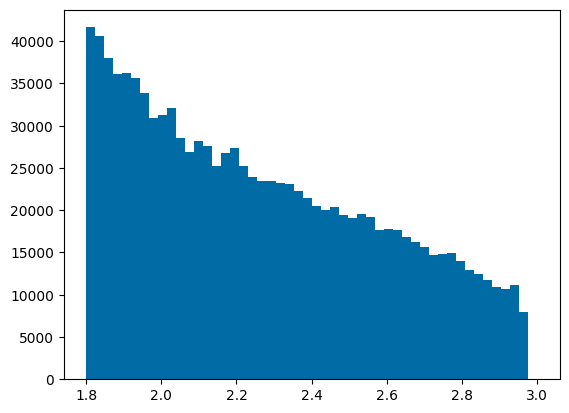

In [43]:
cc=plt.hist(z,bins=50,range=[1.8,3])

In [20]:
# now create a gaussian centred at 2.5 with width 0.3
def norm_dist(x, mu=2.5, sig=0.2):
    return 1/sig/np.sqrt(2*np.pi)*np.exp(-0.5*(x-mu)**2/(2*sig)**2)

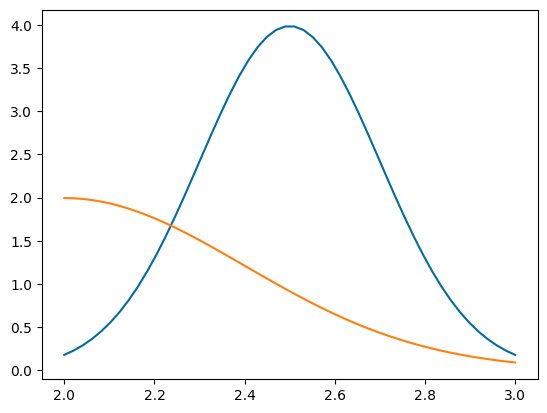

In [23]:
x = np.linspace(2,3,50)
plt.plot(x, norm_dist(x,sig=0.1))
plt.plot(x, norm_dist(x,mu=2.0))

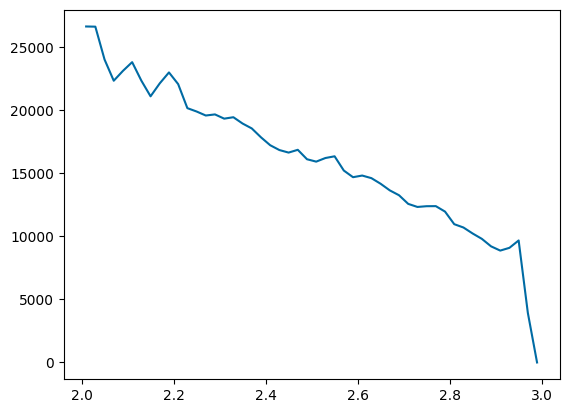

In [27]:
# what's maximum number we can get?
zsamp = (cc[1][1:]+ cc[1][:-1])/2.
number = cc[0]
plt.plot(zsamp,number)
totnumber = sum(number)
#print(totnumber)

In [50]:
# let's create randomly selected sample for these distribution:
p = norm_dist(z,mu=2.0,sig=0.1)
zchosen2 = np.random.choice(z, size=int(len(z)*0.5), replace=False, p= p/sum(p))

In [ ]:
p = norm_dist(z,sig=0.1)
zchosen = np.random.choice(z, size=int(len(z)*0.5), replace=False, p= p/sum(p))

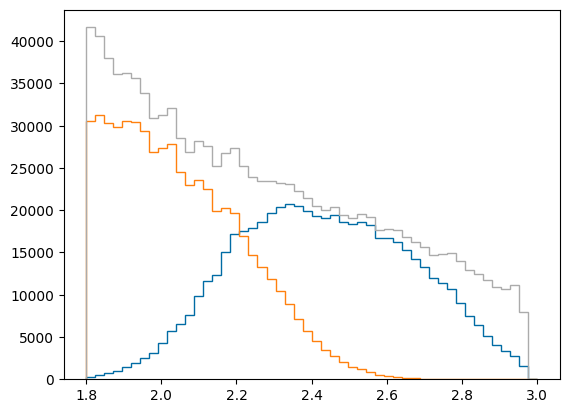

In [51]:
cc1 = plt.hist(zchosen,bins=50,range=[1.8,3],histtype='step')
cc2 = plt.hist(zchosen2,bins=50,range=[1.8,3],histtype='step')
cc=plt.hist(z,bins=50,range=[1.8,3],histtype='step')

In [ ]:
# then also generate the full sample:

Text(0.5, 1.0, 'The photometric tail at $z>1.8$')

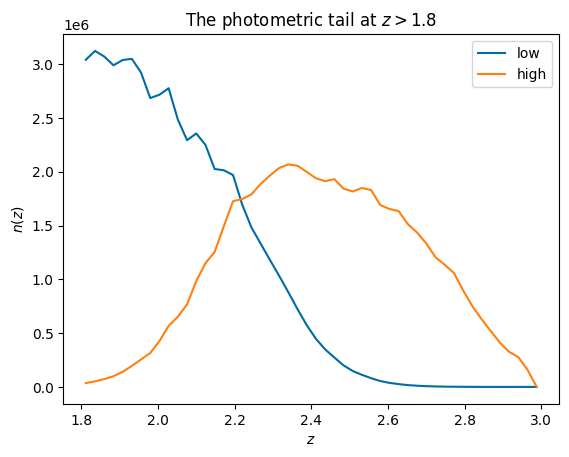

In [59]:
# load the n(z):
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/nz-unknown-low-zmin-1.8-zmax-3.0.fits")
plt.plot(fin[:,0],fin[:,1],label="low")
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/nz-unknown-mid-zmin-1.8-zmax-3.0.fits")
plt.plot(fin[:,0],fin[:,1],label="high")
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.legend()
plt.title("The photometric tail at $z>1.8$")

In [60]:
# now test the routine where I assume an error function peaking at z=1.5

# let's start by load a galaxy file: 
fname = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box_0/gal_box/results/out_srcs_s2_0.fits"
fin = fits.open(fname)

In [62]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =             56285670 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'TYPE    '           / label for field   1                            
TFORM1  = '1J      '           / data format of field: 4-byte INTEGER           
TUNIT1  = 'NA      '           / physical unit of field                         
TTYPE2  = 'RA      '           / label for field   2                            
TFORM2  = '1E      '        

In [84]:
z = (fin[1].data['Z_COSMO'] + fin[1].data['DZ_RSD'])[::100]

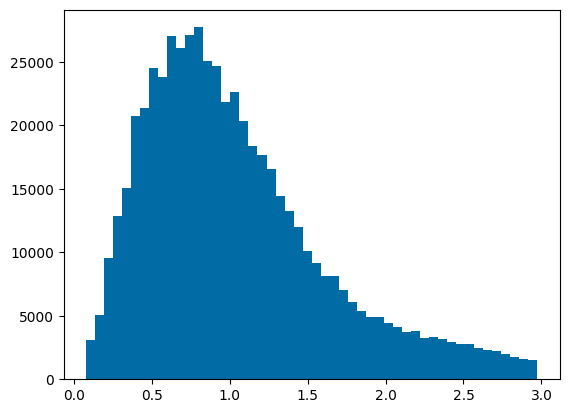

In [86]:
cc = plt.hist(z, bins=50)
zzz=(cc[1][1:] + cc[1][:-1])*0.5
nnn=cc[0]

let's compute the last bin c.f. https://github.com/LSSTDESC/CCLX/blob/master/binning.py

In [88]:
def srd_tot_nz(z, z0=0.11, alpha=0.68):
    """
    params from SRD Eq.5
    CCLX: 
    alpha: 0.68  # power law index in the exponent (check eq. 5 in the SRD paper)
    z_0: 0.11  # pivot redshift (check eq. 5 in the SRD paper)
    """
    dz = z[1]-z[0]
    nz = z**2* np.exp(-(z/z0)**alpha)
    # normalize
    nz = nz/sum(nz)/dz
    
    return nz

In [89]:
# okay now figure out the bins:
from scipy.integrate import simpson, cumulative_trapezoid
def compute_equal_number_bounds(redshift_range, redshift_distribution, n_bins):
        """
        Determines the redshift values that divide the distribution into bins
        with an equal number of galaxies.

        Arguments:
            redshift_range (array): an array of redshift values
            redshift_distribution (array): the corresponding redshift distribution defined over redshift_range
            n_bins (int): the number of tomographic bins

        Returns:
            An array of redshift values that are the boundaries of the bins.
        """

        # Calculate the cumulative distribution
        cumulative_distribution = cumulative_trapezoid(redshift_distribution, redshift_range, initial=0)
        total_galaxies = cumulative_distribution[-1]

        # Find the bin edges
        bin_edges = []
        for i in range(1, n_bins):
            fraction = i / n_bins * total_galaxies
            # Find the redshift value where the cumulative distribution crosses this fraction
            bin_edge = np.interp(fraction, cumulative_distribution, redshift_range)
            bin_edges.append(bin_edge)

        return [redshift_range[0]] + bin_edges + [redshift_range[-1]]

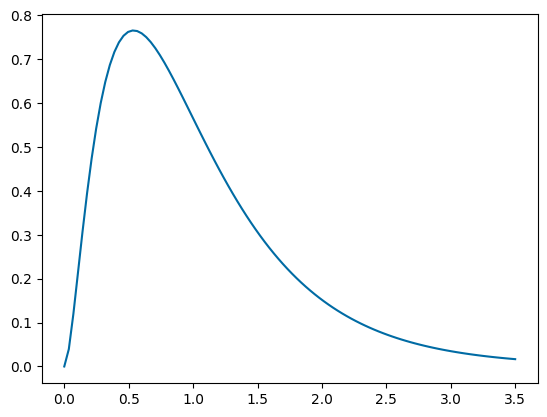

In [93]:
z = np.linspace(0,3.5,100)
plt.plot(z, srd_tot_nz(z))

In [94]:
redshift_range = z
redshift_distribution = srd_tot_nz(z)
n_bins=5
bins = compute_equal_number_bounds(redshift_range, redshift_distribution, n_bins)

In [95]:
bins

[0.0,
 0.45032479030343636,
 0.7161192966827906,
 1.029489973599994,
 1.5084734117154046,
 3.5]

In [96]:
from scipy.special import erf
def true_redshift_distribution(upper_edge, lower_edge, variance, bias, redshift_range, redshift_distribution):
    """A function that returns the true redshift distribution of a galaxy sample.
     The true distribution of galaxies is defined as a convolution of an overall galaxy redshift distribution and
     a probability distribution p(z_{ph}|z)  at a given z (z_{ph} is a photometric distribution at a given z).
     Overall galaxy redshift distribution is a Smail type distribution (n(z) = (z/z_0)^alpha exp[-(z/z_0)^beta]).
     The true distribution defined here is following Ma, Hu & Huterer 2018
      (see https://arxiv.org/abs/astro-ph/0506614 eq. 6).

       Arguments:
           upper_edge (float): upper edge of the redshift bin
           lower_edge (float): lower edge of the redshift bin
           variance (float): variance of the photometric distribution
           bias (float): bias of the photometric distribution
        Returns:
            true_redshift_distribution (array): true redshift distribution of a galaxy sample"""
    # Calculate the scatter
    scatter = variance * (1 + redshift_range)
    # Calculate the upper and lower limits of the integral
    lower_limit = (upper_edge - redshift_range + bias) / np.sqrt(2) / scatter
    upper_limit = (lower_edge - redshift_range + bias) / np.sqrt(2) / scatter

    # Calculate the true redshift distribution
    true_redshift_distribution = 0.5 * np.array(redshift_distribution) * (erf(upper_limit) - erf(lower_limit))

    return true_redshift_distribution

In [97]:
sigma_z = 0.05  # photo-z variance (scatter = 0.05 * (1 + z))
z_bias = 0

source_z_bias_list = np.repeat(z_bias,n_bins)
source_z_variance_list = np.repeat(sigma_z, n_bins)

source_redshift_distribution_dict = {}
# Loop over the bins: each bin is defined by the upper and lower edge of the bin
for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
    z_bias = source_z_bias_list[index]
    z_variance = source_z_variance_list[index]
    source_redshift_distribution_dict[index] = true_redshift_distribution(x1, x2, z_variance, z_bias, redshift_range, redshift_distribution)

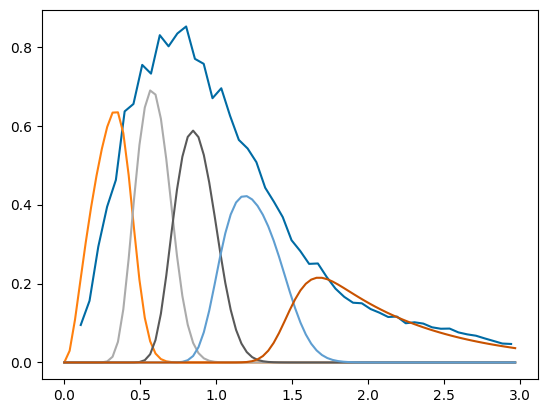

In [230]:
z = np.linspace(0,3.5,100)
useind = z<3
plt.plot(zzz, nnn/sum(nnn)/(zzz[1]-zzz[0]))
for ii in range(5):
    plt.plot(z[useind], source_redshift_distribution_dict[ii][useind])
    if ii == 0:
        nz = np.c_[z[useind], source_redshift_distribution_dict[ii][useind]]
    else:
        nz = np.c_[nz, source_redshift_distribution_dict[ii][useind]]

In [231]:
nz = np.c_[z[useind], source_redshift_distribution_dict[4][useind]]

In [333]:
z = (fin[1].data['Z_COSMO'] + fin[1].data['DZ_RSD'])[::100]

scale=9

# now let's use our routine to see if this works:
Nbins = nz.shape[1]-1

# binning of the target hist
zsamp = nz[:,0]
dz = zsamp[1]-zsamp[0] # assumes linear sampling
zbin_edges = np.append(zsamp-dz/2., zsamp[-1]+dz/2.)

if Nbins > 1:
    # combination of all target hist
    nz_tomo_tot = np.sum(nz[:,1:], axis=1)
    # un-normalized target histogram in each bin
    nz_tomo_nonorm = nz[:,1:]/sum(nz_tomo_tot)/dz
    # normalize
    nz_tomo_tot = nz_tomo_tot/sum(nz_tomo_tot)/dz
elif Nbins == 1:
    nz_tomo_tot = nz[:,1]/sum(nz[:,1])/dz
    nz_tomo_nonorm = nz_tomo_tot
    

# now let's get the nz distribution of the sample:
nz_this, ig = np.histogram(z, bins = zbin_edges) # this may take a while
# normalize
nz_this = nz_this/sum(nz_this)/dz

if scale == None:
    # so now figure out the scaling first:
    ratio = nz_tomo_tot/nz_this
    ratio[np.isnan(ratio)]=0
    ratio[np.isinf(ratio)]=0
    scale=ratio.max()

if Nbins >1:
    for ii in range(Nbins):
        use = nz_tomo_nonorm[:,ii]/scale/nz_this
        # the case where use > 1 needs some care
        if sum(use>1)>0:
            raise TypeError("ratio > 1 for Nbins >1. This case is not implemented. exiting...")
        if ii==0:
            ratio= np.c_[zsamp, nz_tomo_nonorm[:,ii]/scale/nz_this]
        else:
            ratio = np.c_[ratio, nz_tomo_nonorm[:,ii]/scale/nz_this]
elif Nbins == 1:
    use = nz_tomo_nonorm/scale/nz_this
    # in the case where scale is provided:
    if sum(use>1)>0:
        use[use>1] = 1
    ratio= np.c_[zsamp, use]

# unbinned objects goes here:
ratio=np.c_[ratio, 1-np.sum(ratio[:,1:],axis=1)]
cumratio = np.cumsum(ratio[:,1:],axis=1)

In [334]:
print(scale)

9


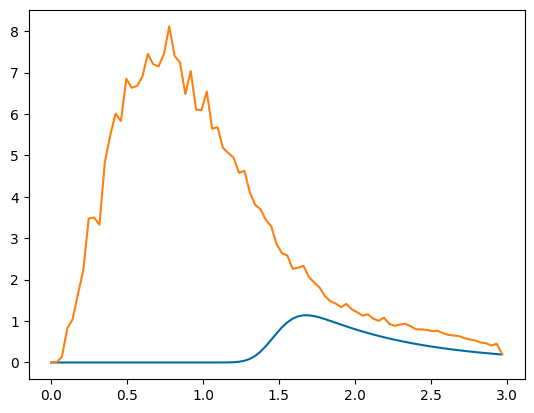

In [335]:
# now check 
plt.plot(nz[:,0], nz_tomo_tot)
plt.plot(nz[:,0], nz_this*scale)

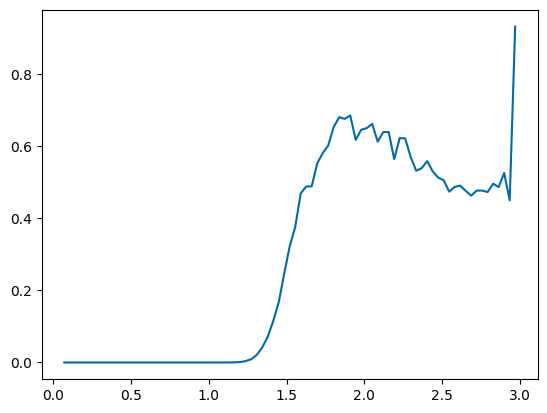

In [336]:
plt.plot(nz[:,0], use)

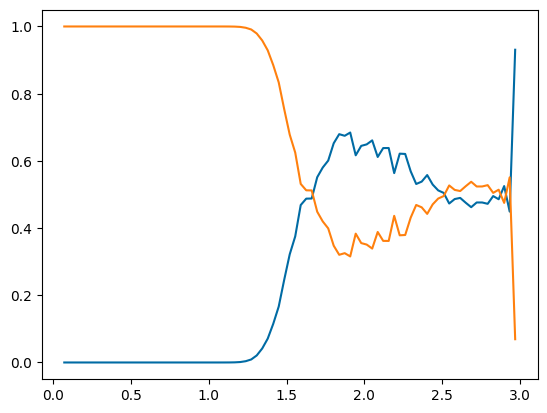

In [337]:
plt.plot(nz[:,0],ratio[:,1:])

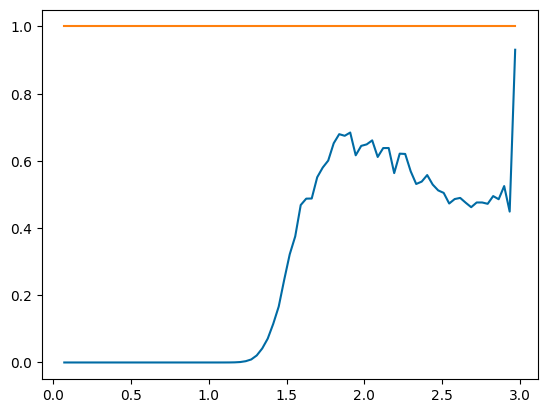

In [338]:
plt.plot(nz[:,0],cumratio)

In [339]:
# we need to modify cumratio such that it is monotonically increasing:
digibins = np.append(np.zeros((cumratio.shape[0],1)), cumratio, axis=1)
# fix any nans to zero
digibins[np.isnan(digibins)]=0
# set last column to one 
digibins[:,-1]=1

ind1 = digibins[:,1]==0
digibins[ind1,0] = -1
ind2 = np.around(digibins[:,-2],5)==1
digibins[ind2,-1]=2

In [340]:
# now assign 
redshift = z

bins = np.digitize(redshift, zbin_edges)
rand = np.random.uniform(size=len(redshift))
tomo_assign = np.zeros(len(redshift))

# now digitize the bins:
for kk in range(len(zbin_edges)-1):
    ind = bins==kk+1
    tomo_assign[ind]=np.digitize(rand[ind], digibins[kk,:])

In [341]:
np.unique(tomo_assign)

array([1., 2.])

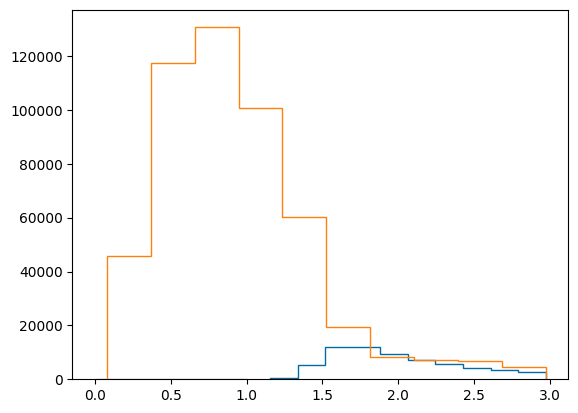

In [342]:
for ii in range(1,4):
    ind = tomo_assign == ii
    cc=plt.hist(z[ind],histtype='step')

In [343]:
len(z[tomo_assign == 1])

62580

In [344]:
# now need to determine the pixel and how many pixels
ra = (fin[1].data['RA'])[::100]
dec = (fin[1].data['DEC'])[::100]
print(ra[:5], dec[:5])

[225.66101 225.044   224.78033  44.54243 224.8134 ] [8.96812  9.40347  9.135592 9.197778 9.372351]


In [345]:
nside=8

In [346]:
pix = hp.ang2pix(nside, ra, dec, lonlat=True)
upix, counts = np.unique(pix, return_counts=True)

# Double check if counts are similar, 
# so we don't have pix split in half et.c
print(counts)

[95020 93779 93524 93021 93006 94507]


In [347]:
print(np.unique(pix))

[340 356 592 608 764 766]


In [348]:
npix =len(np.unique(pix))
area = hp.nside2pixarea(nside, degrees = True)*npix # deg^2
area = area * 60**2 # arcmin^2

In [349]:
print(len(z[tomo_assign == 1])*100/area)

5.393713806903958


In [350]:
srd_require = 27/5.
print(srd_require)

5.4


In [359]:
# load the file to see if things works!

fex = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/unknown-SRD_nz-zmin-0-zmax-3.fits")
fex[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =            108319527 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [360]:
nzex = np.loadtxt('/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/nz-unknown-SRD_nz-zmin-0-zmax-3.txt')

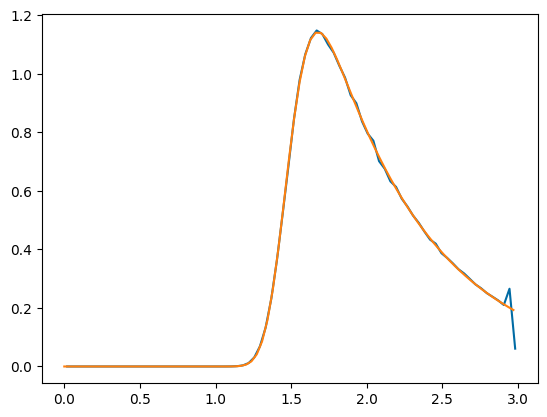

In [361]:
plt.plot(nzex[:,0], nzex[:,1]/sum(nzex[:,1])/(nzex[1,0]-nzex[0,0]))
plt.plot(nz[:,0], nz_tomo_tot)

In [362]:
mapex = hp.read_map("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/galmap-unknown-SRD_nz-zmin-0-zmax-3.fits")

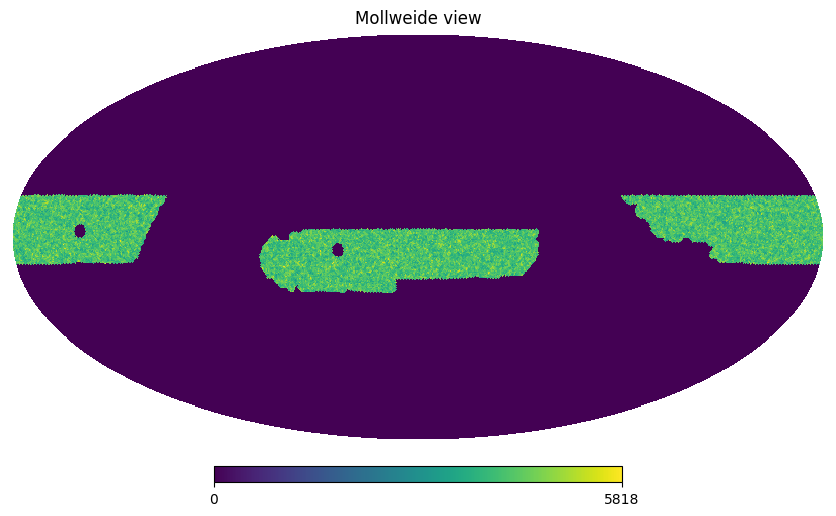

In [363]:
hp.mollview(mapex)

In [364]:
# estimate number density on the map:
nmean = sum(mapex)/sum(mapex>0)
print(nmean)

nside=hp.get_nside(mapex)
area = hp.nside2pixarea(nside,degrees=True)*60**2
ngal = nmean/area
print(ngal)

4138.439940398869
5.478733964780898
